In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
class clustering_pipeline:
    def __init__(self, vectorizer, n_components, reducer):
        self.vectorizer = vectorizer
        self.n_dim = n_components
        self.reducer = reducer(n_components)
        
    def fit(self, text):
        self.vectorizer.fit(text)
        self.vector_data = self.vectorizer.fit_transform(text)
        self.topic_data = self.reducer.fit_transform(self.vector_data)
        self.texts = text

    def tsne(self, n_components, perplexity):
        tsne = TSNE(n_components = n_components, perplexity = perplexity)
        plt.figure(dpi=300)
        vector_tsne = tsne.fit_transform(self.topic_data)
        sns.scatterplot(vector_tsne[:, 0], vector_tsne[:, 1],hue=self.labels_, alpha=0.5, size = 0.5, 
                        palette='rainbow', legend='full')
        plt.title(f'tSNE on topic space using {self.cluster_method}');
        plt.figure(dpi=300)
        plt.hist(self.labels_, bins=self.n_clusters);
        
    def kmeans(self, n_clusters):
        self.km = KMeans(n_clusters=n_clusters)
        self.labels_ = self.km.fit_predict(self.vector_data)
        self.cluster_method='kmeans'
        self.n_clusters=n_clusters
        
    def db(self, eps, min_samples):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(self.x)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        self.labels_ = db.labels_
        self.cluster_method='db'
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        self.n_clusters=n_clusters

    def spectral(self, article, num_to_return, n_clusters):
        sc = SpectralClustering(n_clusters=n_clusters)
        self.labels_ = sc.fit_predict(self.x)
        self.cluster_method='spectral'
        self.n_clusters=n_clusters
        
    def meanshift(self, quantile, n_samples):
        bandwidth = estimate_bandwidth(self.x, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(self.x)
        self.labels_ = ms.labels_
        self.cluster_method = 'meanshift'
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(self.labels_)
        self.n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)

        result_texts = [self.texts[i] for i in results[1][0]]
        
        return result_texts

In [3]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2))

def find_cluster_closest_cosine_verses(cluster):
    overall_clusters=[]
    for number in set(cluster.labels_):
        cluster_center = cluster.km.cluster_centers_[number]
        distances=[]
    for index, vector in enumerate(cluster.topic_data):
        dist = cosine_similarity(cluster_center,vector)
        distances.append((dist, index))
    distances.sort()
    indices=[x[1] for x in distances[-4:]]
    print(distances[-4:])
    for i in indices:
        print(df.review.iloc[i])

In [4]:
df = pd.read_pickle('cleaned_df.pkl')
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


In [72]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.2, min_df= 0.08)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.2, min_df = 0.08)

cv_data = count_vectorizer.fit_transform(df.ReviewText)
tfidf_data = tfidf_vectorizer.fit_transform(df.ReviewText)

In [73]:
cv_data.shape

(22628, 38)

In [78]:
n_comp = 20
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

# lsa_tfidf

In [75]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

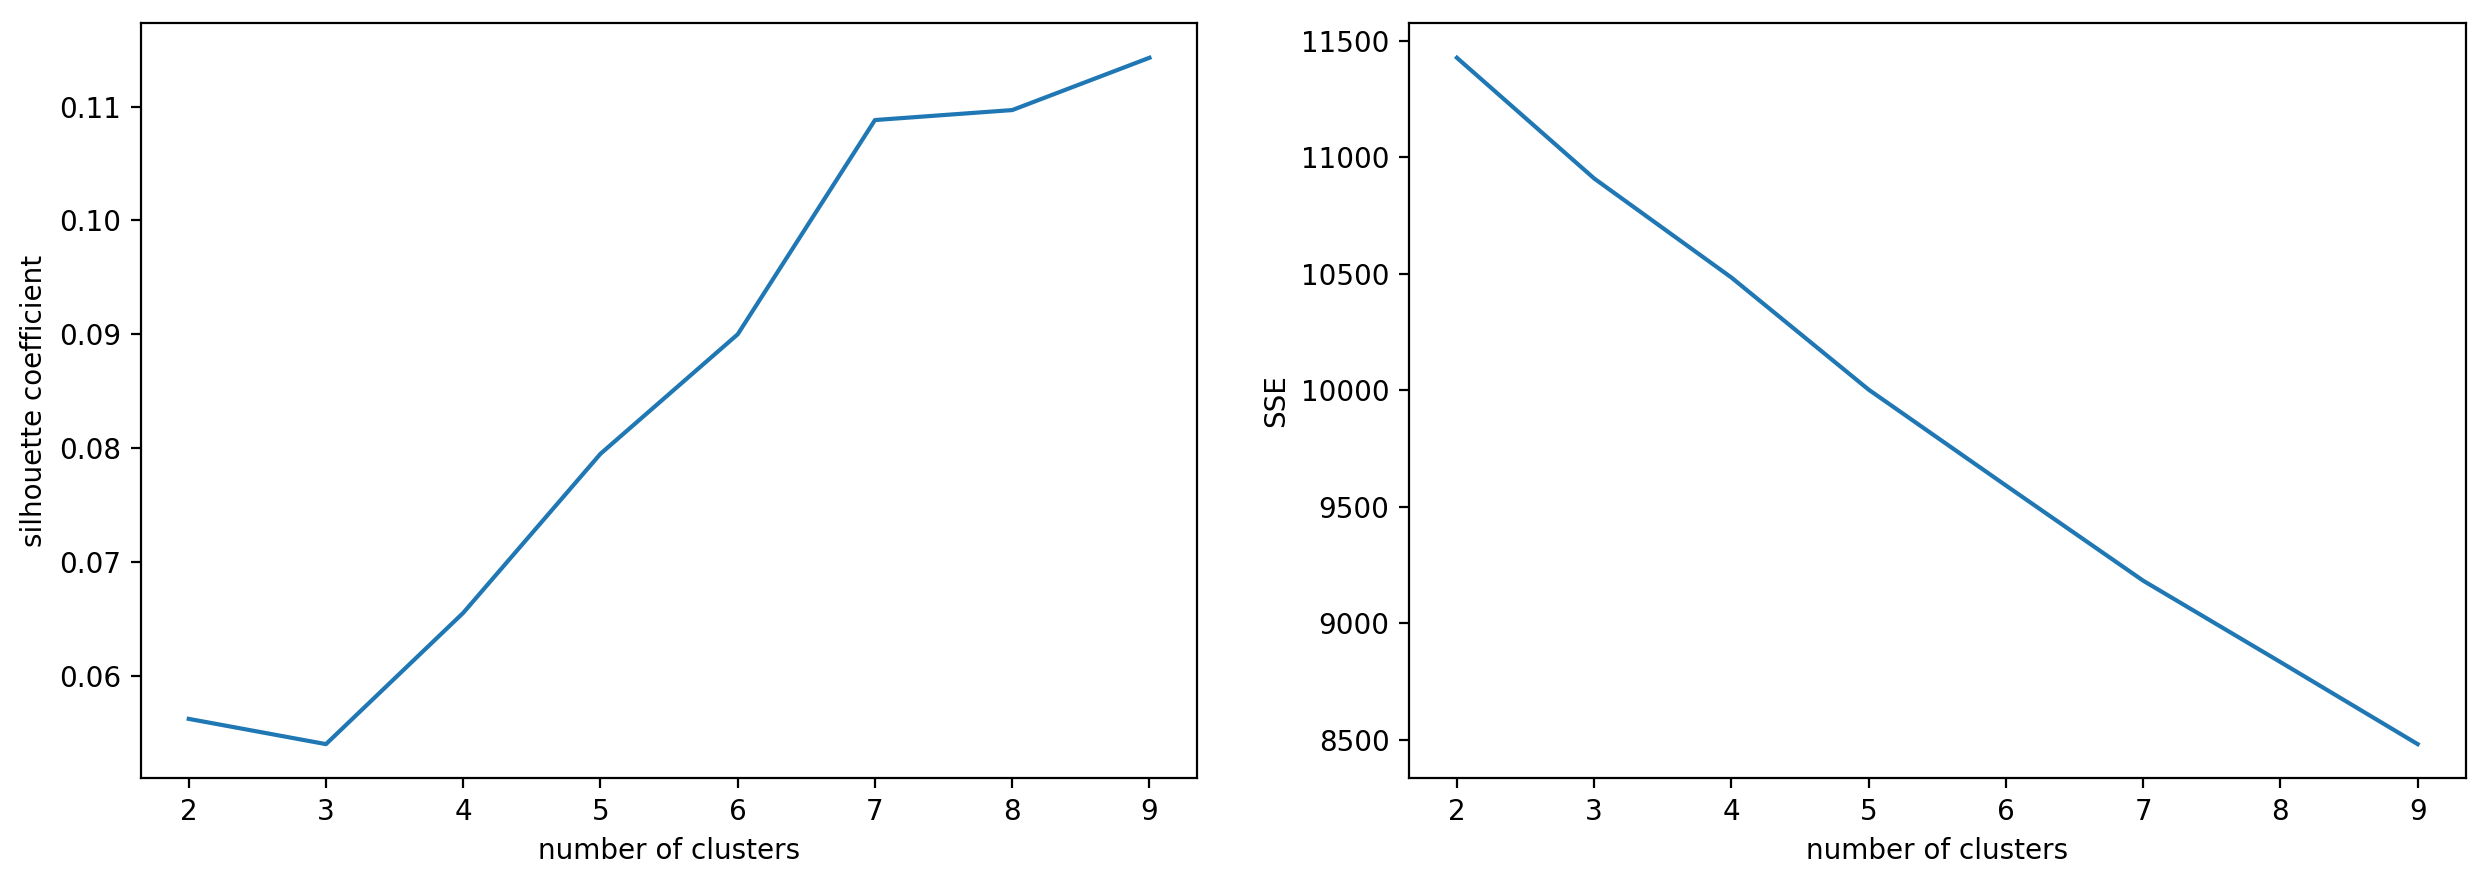

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [79]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 11406.237825
# clusters:  3   Inertia: 10877.033214
# clusters:  4   Inertia: 10450.669985
# clusters:  5   Inertia: 9977.903505
# clusters:  6   Inertia: 9598.605187
# clusters:  7   Inertia: 9209.205000
# clusters:  8   Inertia: 8796.399542
# clusters:  9   Inertia: 8510.299628
# clusters: 10   Inertia: 8213.928716
# clusters: 11   Inertia: 7979.315045
# clusters: 12   Inertia: 7708.358759
# clusters: 13   Inertia: 7528.264759
# clusters: 14   Inertia: 7303.982189
# clusters: 15   Inertia: 7082.039985
# clusters: 16   Inertia: 6957.692182
# clusters: 17   Inertia: 6777.566973
# clusters: 18   Inertia: 6662.916479
# clusters: 19   Inertia: 6570.144266
# clusters: 20   Inertia: 6488.559761
# clusters: 21   Inertia: 6372.926379
# clusters: 22   Inertia: 6302.542832
# clusters: 23   Inertia: 6198.563260
# clusters: 24   Inertia: 6157.729460


(700, 1300)

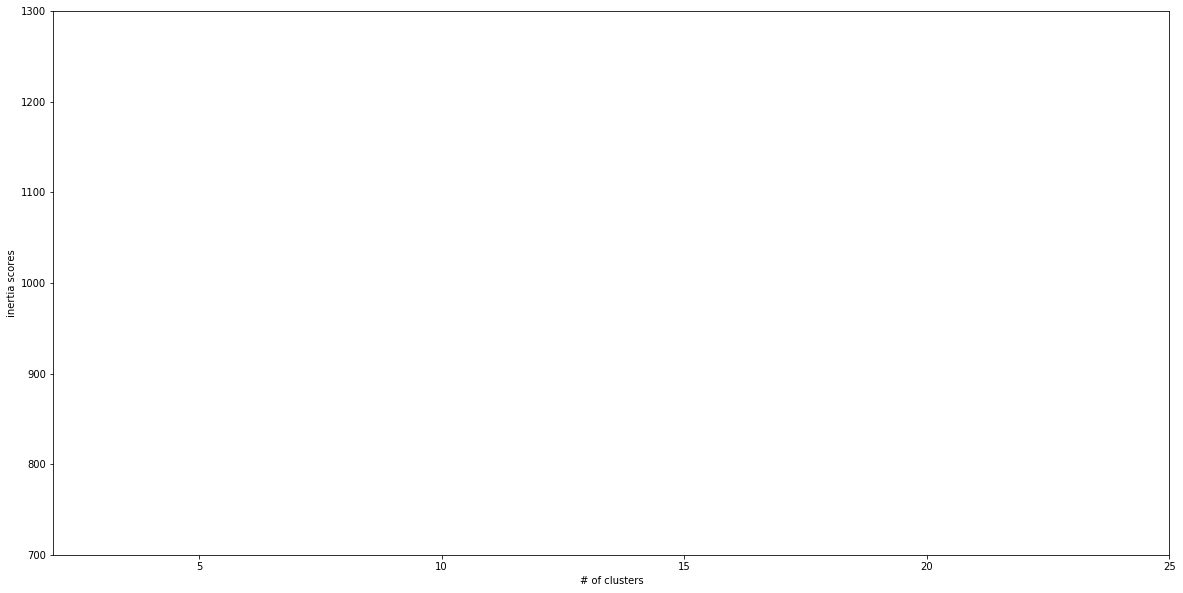

In [80]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((700,1300))

# lsa_cv

In [81]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_cv_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_cv_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

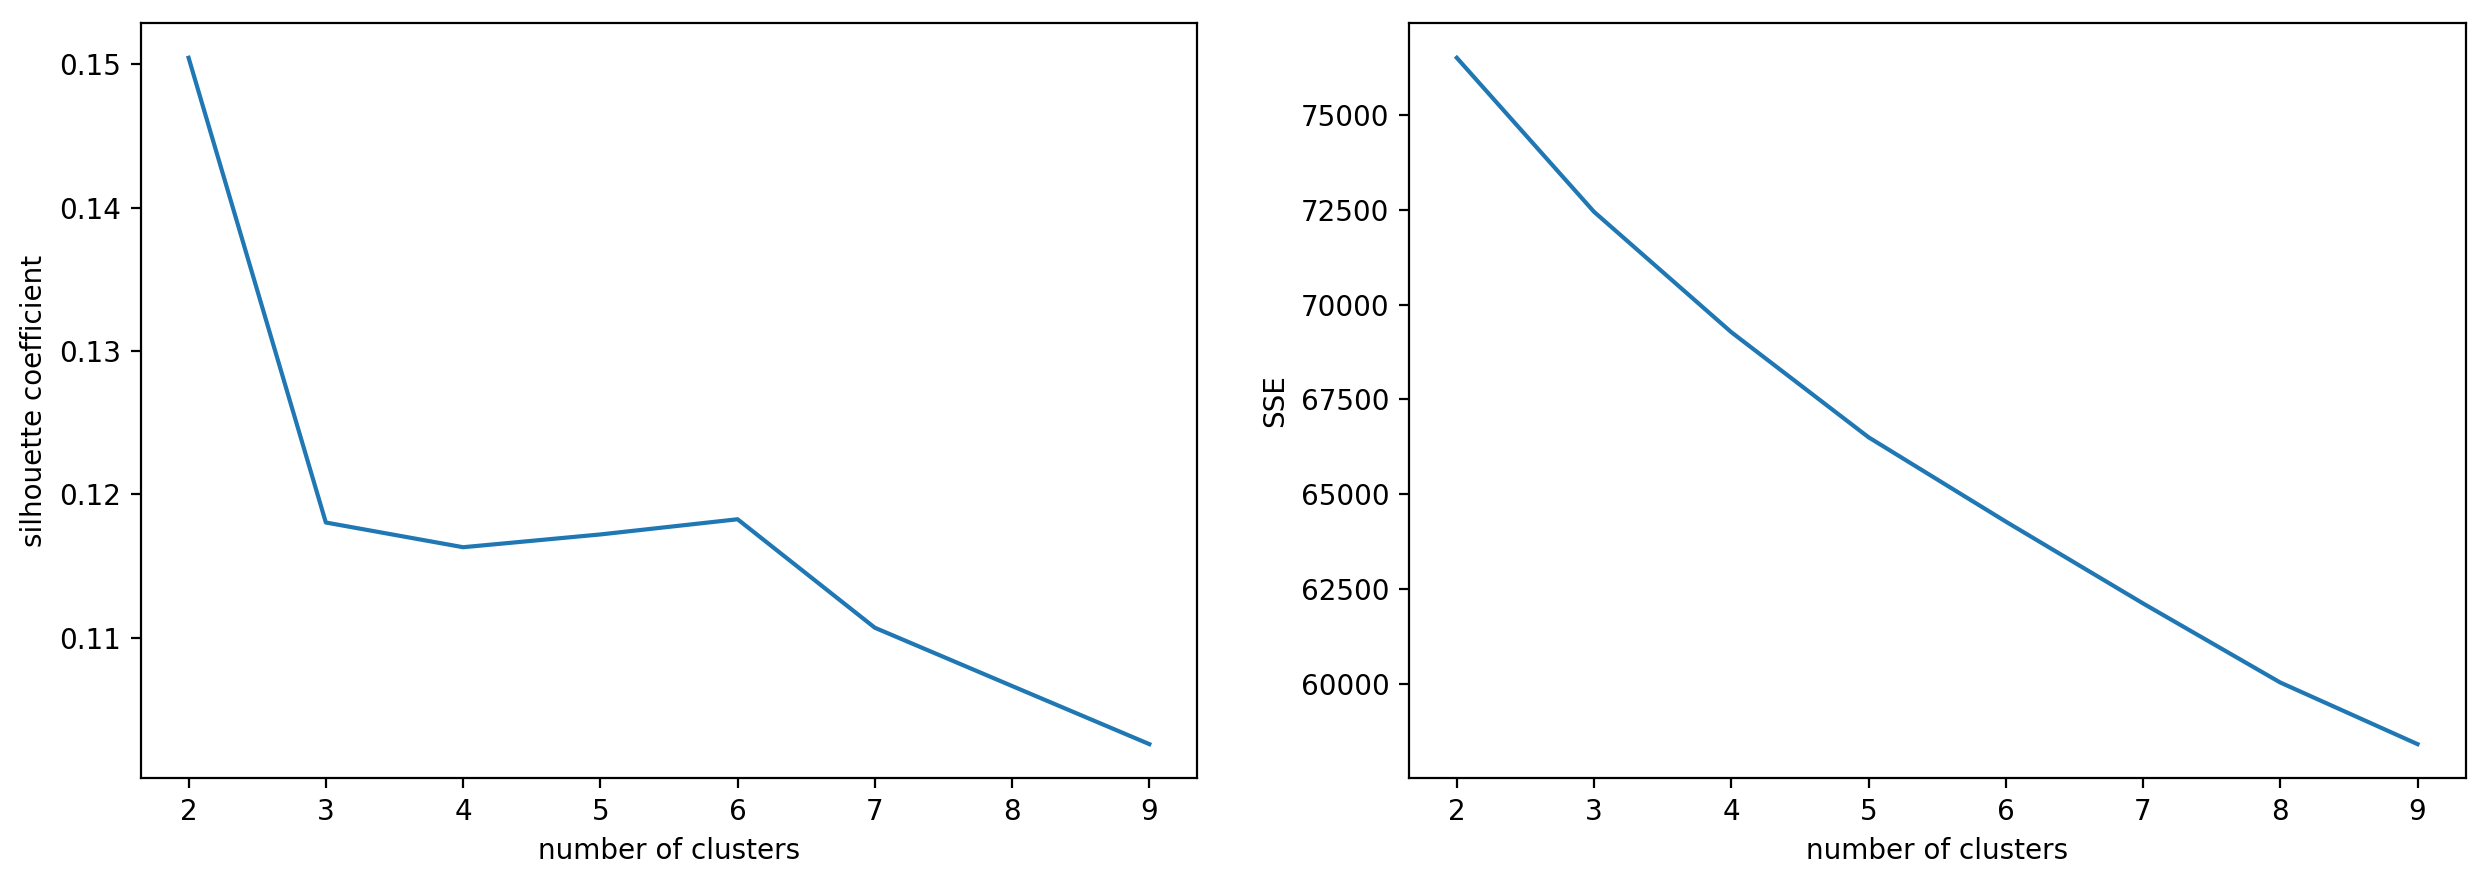

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [83]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 76499.944433
# clusters:  3   Inertia: 72442.312420
# clusters:  4   Inertia: 69586.931790
# clusters:  5   Inertia: 66761.749354
# clusters:  6   Inertia: 64507.656990
# clusters:  7   Inertia: 62126.656053
# clusters:  8   Inertia: 60113.965199
# clusters:  9   Inertia: 58638.892362
# clusters: 10   Inertia: 56870.491818
# clusters: 11   Inertia: 55285.786907
# clusters: 12   Inertia: 54215.265068
# clusters: 13   Inertia: 52912.733572
# clusters: 14   Inertia: 52075.274249
# clusters: 15   Inertia: 51208.687807
# clusters: 16   Inertia: 50163.797143
# clusters: 17   Inertia: 49620.695760
# clusters: 18   Inertia: 48911.941866
# clusters: 19   Inertia: 48237.865361
# clusters: 20   Inertia: 47989.362027
# clusters: 21   Inertia: 47387.458206
# clusters: 22   Inertia: 46978.700272
# clusters: 23   Inertia: 46392.557296
# clusters: 24   Inertia: 45948.938373


(700, 1300)

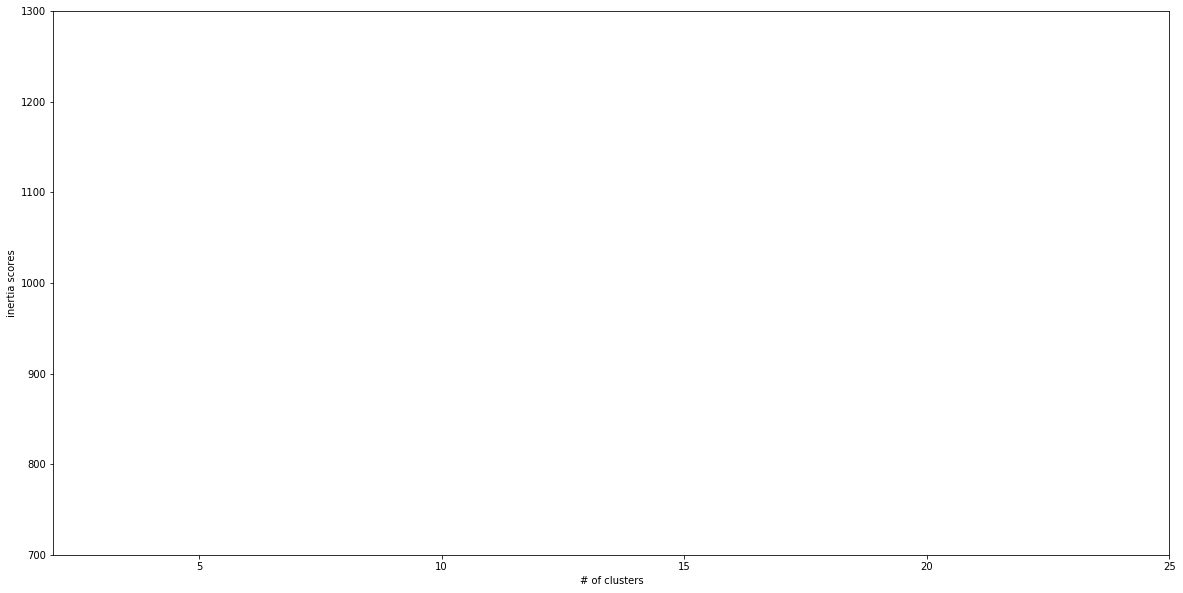

In [84]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((700,1300))

# nmf_tfidf

In [85]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

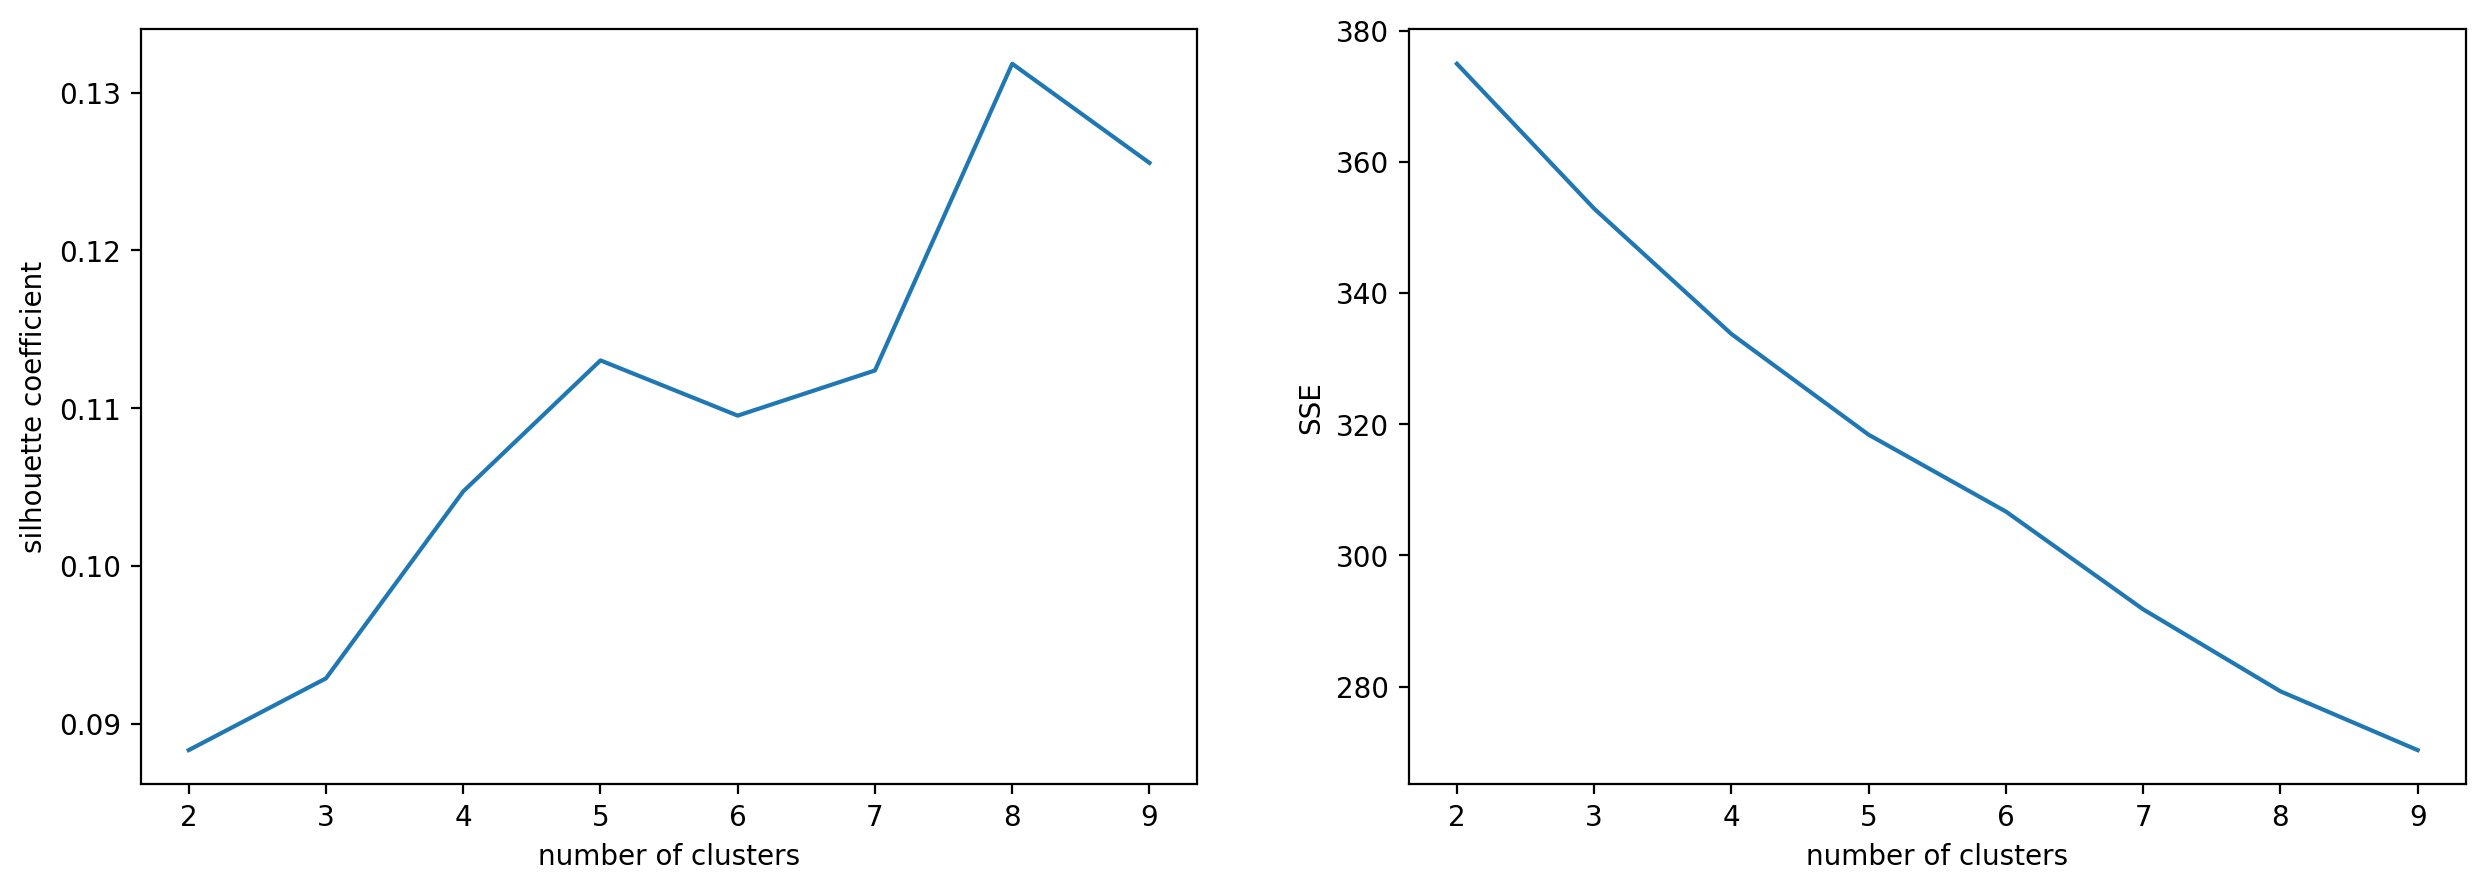

In [86]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [87]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 374.943587
# clusters:  3   Inertia: 353.926003
# clusters:  4   Inertia: 337.800362
# clusters:  5   Inertia: 318.402919
# clusters:  6   Inertia: 304.415685
# clusters:  7   Inertia: 290.943217
# clusters:  8   Inertia: 279.397303
# clusters:  9   Inertia: 267.725188
# clusters: 10   Inertia: 259.919395
# clusters: 11   Inertia: 249.110752
# clusters: 12   Inertia: 240.308085
# clusters: 13   Inertia: 232.196010
# clusters: 14   Inertia: 225.449592
# clusters: 15   Inertia: 219.146803
# clusters: 16   Inertia: 210.548056
# clusters: 17   Inertia: 204.910352
# clusters: 18   Inertia: 203.604469
# clusters: 19   Inertia: 198.028662
# clusters: 20   Inertia: 191.872710
# clusters: 21   Inertia: 191.512291
# clusters: 22   Inertia: 185.461388
# clusters: 23   Inertia: 184.477387
# clusters: 24   Inertia: 182.399717


(700, 1300)

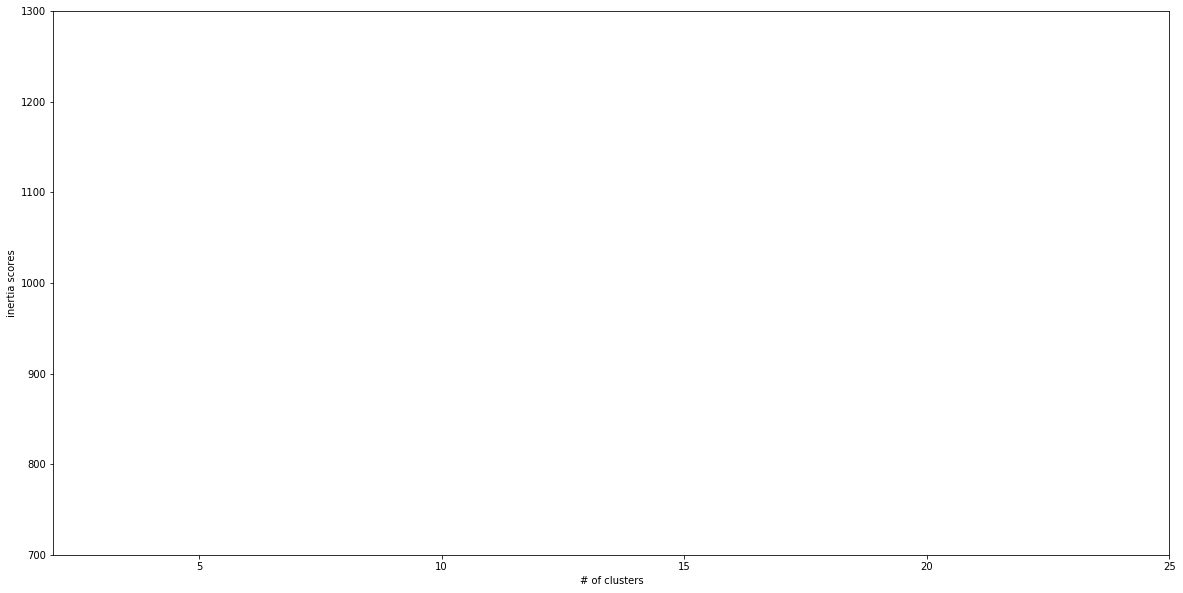

In [88]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((700,1300))

# nmf_cv

In [89]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_cv_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_cv_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

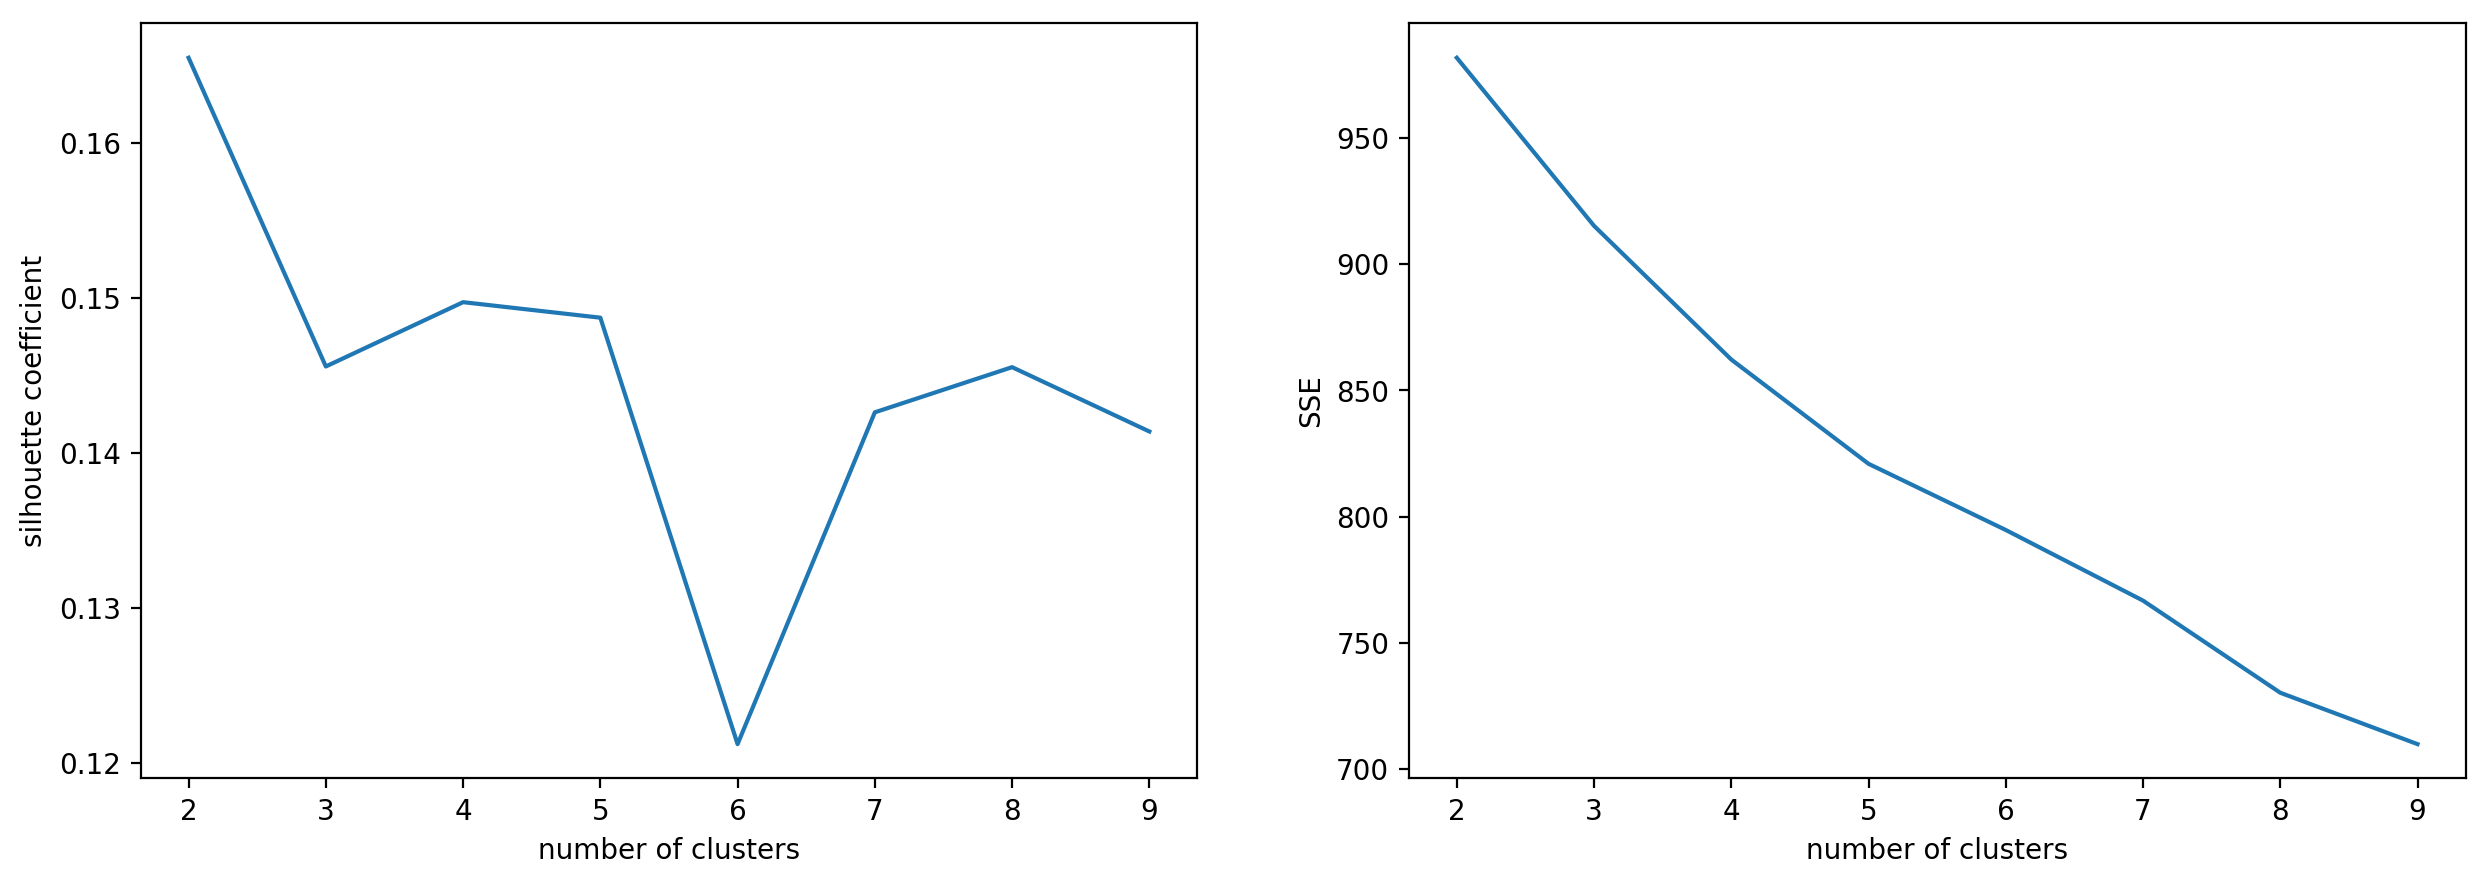

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [91]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 981.721028
# clusters:  3   Inertia: 915.184479
# clusters:  4   Inertia: 868.330175
# clusters:  5   Inertia: 825.400535
# clusters:  6   Inertia: 790.441986
# clusters:  7   Inertia: 758.943624
# clusters:  8   Inertia: 744.034242
# clusters:  9   Inertia: 710.832621
# clusters: 10   Inertia: 693.689013
# clusters: 11   Inertia: 670.028355
# clusters: 12   Inertia: 655.304224
# clusters: 13   Inertia: 646.734011
# clusters: 14   Inertia: 625.052222
# clusters: 15   Inertia: 614.660091
# clusters: 16   Inertia: 605.038023
# clusters: 17   Inertia: 595.334474
# clusters: 18   Inertia: 584.102626
# clusters: 19   Inertia: 573.602725
# clusters: 20   Inertia: 571.412279
# clusters: 21   Inertia: 561.278137
# clusters: 22   Inertia: 549.953727
# clusters: 23   Inertia: 548.538047
# clusters: 24   Inertia: 542.674472


(700, 1300)

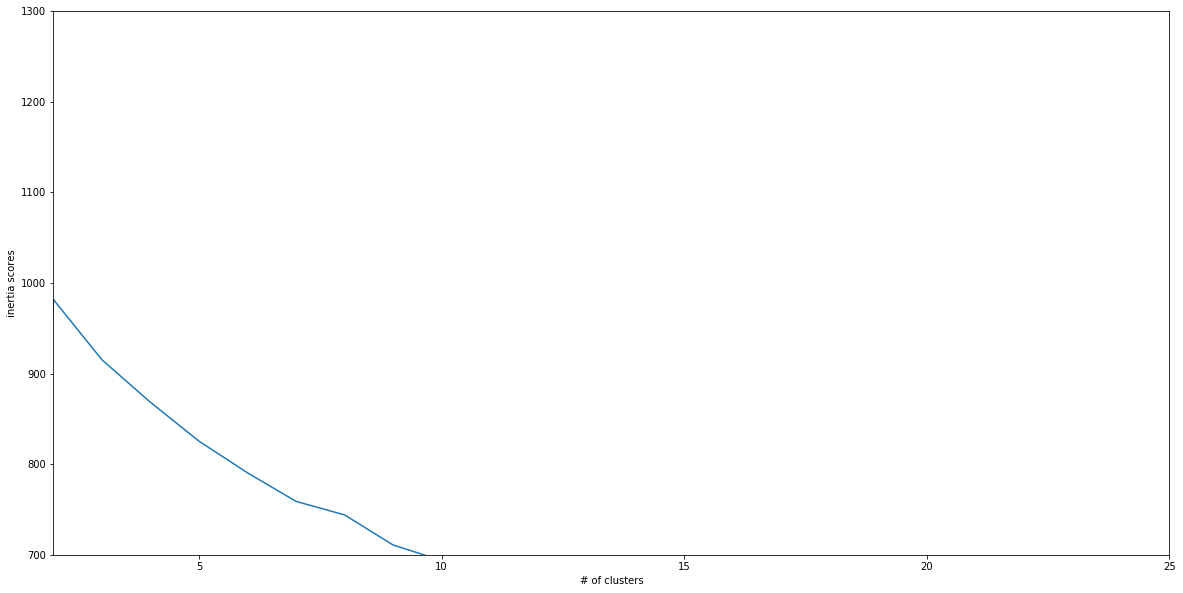

In [92]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((700,1300))